# cluster users by ratings 

In [76]:
import helper as h
import pyspark.sql.functions as F
import pymongo

from pyspark.mllib.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

import matplotlib.pyplot as plt
import pandas as pd

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

# Grep data

In [3]:
# Requires the PyMongo package.
# https://api.mongodb.com/python/current
top_mv = 20
client = pymongo.MongoClient('mongodb://127.0.0.1:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
db = client['movie_dataset']
result = db['ratings'].aggregate([
    {'$group': {
            '_id': '$movieId', 
            'count': {'$sum': 1}
    }}, 
    {'$sort': {'count': -1}}, 
    {'$limit': top_mv}, 
    {'$project': {'_id': 1}}
])
fields = {str(r['_id']):1 for r in result}

In [4]:
TOT = 270896 
limit = TOT//3
#take the first 1/3 of the users and the top 2k voted films
pipeline = [
    {"$limit":limit},
    {"$project":fields}
]

#pipeline

In [23]:
spark = h.get_session("movie_dataset", "reshaped_ratings")
df = spark.read.format(h.FORMAT).option("pipeline",pipeline).load().na.fill(0)
df.createOrReplaceTempView("ratings")

## Split dataset

In [40]:
#USE_PERCENTAGE = 0.3
#train, test, consider later
#split = [.7*USE_PERCENTAGE, .3*USE_PERCENTAGE, 1-USE_PERCENTAGE]
split = [.7, .3]
df_train, df_test = df.randomSplit(split, 42)

In [130]:
rdd_test = df_test.select(*df_test.columns[:-1]).rdd.map(lambda x: (*x,))

In [131]:
rdd = df_train.select(*df_train.columns[:-2]).rdd.map(lambda x: (*x,))

## KMeans

In [132]:
kmeans = KMeans.train(rdd, 15,seed=42)

In [141]:
pred_df = kmeans.predict(rdd_test).map(lambda x: (x, )).toDF().toPandas()

In [142]:
c = pred_df._1.values
pred_df

,_1
0,8
1,1
2,5
3,1
4,2
...,...
79866,5
79867,5
79868,5
79869,5


## Principal components

In [135]:
mat = RowMatrix(rdd)
mat_test = RowMatrix(rdd_test)
pc = mat.computePrincipalComponents(2)

In [136]:
projected = mat_test.multiply(pc)

In [137]:
projected_df = projected.rows.map(lambda x: (x, )).toDF().toPandas()

In [138]:
x = projected_df._1.apply(lambda v: v[0]).values
y = projected_df._1.apply(lambda v: v[1]).values

In [139]:
x -= x.mean()
x /= x.max()

In [147]:
y[c==1]

array([-0.01299552, -0.17779811,  0.        , ..., -0.28409648,
       -0.28409648, -0.31893968])

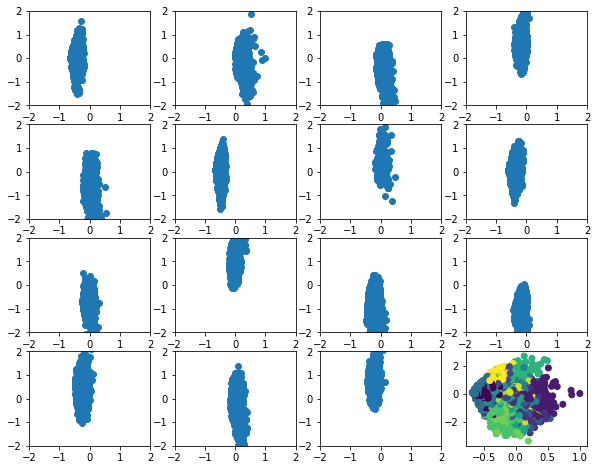

In [163]:
plt.figure(figsize=(10,8))

for i in range(15):
    ax = plt.subplot(4,4,i+1)
    plt.ylim([-2,2])
    plt.xlim([-2,2])
    plt.scatter(x[c==i], y[c==i])

plt.subplot(4,4,16)
plt.scatter(x, y, c=c)

In [114]:
y

array([ 1.02530670e+00, -1.24010890e+00,  4.37521760e-04, ...,
       -4.41888529e+00, -4.41888522e+00, -4.41888475e+00])